# Fonction unique avec Cross Validation + recherche des hyperparamètres

Le code charge les données d'entraînement et de test, les nettoie et les prépare en traitant les valeurs manquantes et en encodant les variables catégorielles. Ensuite, il utilise plusieurs modèles de machine learning pour prédire les résultats, en ajustant les hyperparamètres de chaque modèle pour obtenir de meilleures performances. Enfin, il évalue ces modèles en calculant diverses métriques (comme l'AUC, la précision, le rappel, le score F1) et mesure le temps de 1000 prédictions pour chaque modèle, et affiche les résultats et les meilleurs hyperparamètres.

In [8]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
import lightgbm as lgb
import logging
import sys
import time
from tabulate import tabulate
import warnings

warnings.filterwarnings("ignore")


def measure_prediction_time(model, X, n_predictions=1000):
    """Mesurer le temps de prédiction moyen sur n_predictions échantillons."""
    start_time = time.time()
    for _ in range(n_predictions):
        _ = model.predict_proba(X)[:, 1]
    end_time = time.time()
    elapsed_time = end_time - start_time
    return "{:.2f} s".format(elapsed_time)
import sys
import logging
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
import lightgbm as lgb
from tabulate import tabulate

# Assurez-vous que toutes les fonctions utilitaires sont correctement définies, par exemple, `measure_prediction_time`.

def process_and_predict(train_file, test_file):
    print("Début du processus de prédiction...")
    
    # Configurer le logging pour ignorer les messages d'information de LightGBM
    logging.getLogger('lightgbm').setLevel(logging.ERROR)
    
    print("Chargement des données d'entraînement et de test...")
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    # Convertir toutes les colonnes en numériques en utilisant LabelEncoder
    print("Encodage des variables catégorielles...")
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    # Séparer les données d'entraînement et les labels
    print("Séparation des données d'entraînement et des labels...")
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    # Préparer les données de test sans l'identifiant
    print("Préparation des données de test...")
    test = app_test.drop(columns=['SK_ID_CURR'])
    
    # S'assurer que les colonnes sont alignées avant l'imputation
    print("Alignement des colonnes de données d'entraînement et de test...")
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    # Imputer les valeurs manquantes avec la médiane
    print("Imputation des valeurs manquantes...")
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    # Normaliser les colonnes numériques
    print("Normalisation des données...")
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    # Convertir les matrices numpy en DataFrames pandas
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    print("Création et entraînement des modèles de base...")
    
    # Créer et entraîner le DummyClassifier
    print("Entraînement du DummyClassifier...")
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(train_final, train_labels)
    dummy_predictions = dummy_clf.predict_proba(test_final)[:, 1]
    dummy_auc = roc_auc_score(train_labels, dummy_clf.predict_proba(train_final)[:, 1])
    dummy_time = measure_prediction_time(dummy_clf, test_final)
    
    # Définir les paramètres pour GridSearchCV pour LogisticRegression
    print("Entraînement du modèle LogisticRegression...")
    log_reg_params = {'C': [0.1, 0.01]}
    log_reg = LogisticRegression(max_iter=5000)
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='roc_auc')
    log_reg_grid.fit(train_final, train_labels)
    log_reg_auc = roc_auc_score(train_labels, log_reg_grid.predict_proba(train_final)[:, 1])
    log_reg_time = measure_prediction_time(log_reg_grid, test_final)
    
    # Définir les paramètres pour GridSearchCV pour DecisionTreeClassifier
    print("Entraînement du modèle DecisionTreeClassifier...")
    tree_params = {'max_depth': [5, 7, 10], 'min_samples_split': [10, 20, 50]}
    decision_tree = DecisionTreeClassifier()
    tree_grid = GridSearchCV(decision_tree, tree_params, cv=5, scoring='roc_auc')
    tree_grid.fit(train_final, train_labels)
    tree_auc = roc_auc_score(train_labels, tree_grid.predict_proba(train_final)[:, 1])
    tree_time = measure_prediction_time(tree_grid, test_final)
    
    # Définir les paramètres pour GridSearchCV pour RandomForestClassifier
    print("Entraînement du modèle RandomForestClassifier...")
    rf_params = {'n_estimators': [10, 50, 100], 'max_depth': [5, 7, 10]}
    random_forest = RandomForestClassifier(n_jobs=-1)
    rf_grid = GridSearchCV(random_forest, rf_params, cv=5, scoring='roc_auc')
    rf_grid.fit(train_final, train_labels)
    rf_auc = roc_auc_score(train_labels, rf_grid.predict_proba(train_final)[:, 1])
    rf_time = measure_prediction_time(rf_grid, test_final)
    
    # Rediriger stdout pour éviter les messages d'information de LightGBM
    print("Redirection de stdout pour LightGBM et CatBoost...")
    original_stdout = sys.stdout
    sys.stdout = open('/dev/null', 'w')  # Sur Unix/Linux/Mac
    
    # Définir les paramètres pour GridSearchCV pour CatBoostClassifier
    print("Entraînement du modèle CatBoostClassifier...")
    catboost_params = {'depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.1, 0.3]}
    catboost_model = CatBoostClassifier(iterations=100, loss_function='Logloss', verbose=0)
    catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, scoring='roc_auc')
    catboost_grid.fit(train_final, train_labels)
    catboost_auc = roc_auc_score(train_labels, catboost_grid.predict_proba(train_final)[:, 1])
    catboost_predictions = catboost_grid.predict_proba(test_final)[:, 1]
    catboost_time = measure_prediction_time(catboost_grid, test_final)
    
    # Définir les paramètres pour GridSearchCV pour LightGBMClassifier
    print("Entraînement du modèle LightGBMClassifier...")
    lightgbm_params = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [1, 2, 3, 4, 5],
        'num_leaves': [2**6 - 1, 2**7 - 1, 2**8 - 1]
    }
    lightgbm_model = lgb.LGBMClassifier()
    lightgbm_grid = GridSearchCV(lightgbm_model, lightgbm_params, cv=5, scoring='roc_auc')
    lightgbm_grid.fit(train_final, train_labels)
    lightgbm_auc = roc_auc_score(train_labels, lightgbm_grid.predict_proba(train_final)[:, 1])
    lightgbm_predictions = lightgbm_grid.predict_proba(test_final)[:, 1]
    lightgbm_time = measure_prediction_time(lightgbm_grid, test_final)
    
    # Rétablir stdout
    print("Rétablissement de stdout...")
    sys.stdout = original_stdout

    print("Affichage des meilleurs hyperparamètres pour chaque modèle...")
    best_params = {
        'LogisticRegression': log_reg_grid.best_params_,
        'DecisionTreeClassifier': tree_grid.best_params_,
        'RandomForestClassifier': rf_grid.best_params_,
        'CatBoostClassifier': catboost_grid.best_params_,
        'LightGBMClassifier': lightgbm_grid.best_params_
    }
    
    for model_name, params in best_params.items():
        print(f"{model_name}: {params}")
    
    # Calcul des métriques pour chaque modèle
    print("Calcul des métriques pour chaque modèle...")
    models = {
        'DummyClassifier': dummy_clf,
        'LogisticRegression': log_reg_grid,
        'DecisionTreeClassifier': tree_grid,
        'RandomForestClassifier': rf_grid,
        'CatBoostClassifier': catboost_grid,
        'LightGBMClassifier': lightgbm_grid
    }

    metrics = []

    for name, model in models.items():
        print(f"Calcul des métriques pour le modèle {name}...")
        train_pred = model.predict(train_final)
        auc_score = roc_auc_score(train_labels, model.predict_proba(train_final)[:, 1])
        precision = precision_score(train_labels, train_pred, zero_division=0)
        recall = recall_score(train_labels, train_pred, zero_division=0)
        f1 = f1_score(train_labels, train_pred, zero_division=0)
        cm = confusion_matrix(train_labels, train_pred)
        cm_str = f"TN: {cm[0, 0]}, FP: {cm[0, 1]}, FN: {cm[1, 0]}, TP: {cm[1, 1]}"
        time_taken = measure_prediction_time(model, test_final)
        metrics.append([name, auc_score, precision, recall, f1, cm_str, time_taken])

    # Affichage des résultats
    print("Affichage des résultats finaux...")
    headers = ['Model', 'AUC', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix', 'Prediction Time (1000 est.)']
    print(tabulate(metrics, headers=headers, tablefmt='grid'))
    
    print("Fin du processus de prédiction.")

# Appel de la fonction avec les fichiers de données
process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')



Début du processus de prédiction...
Chargement des données d'entraînement et de test...
Encodage des variables catégorielles...
Séparation des données d'entraînement et des labels...
Préparation des données de test...
Alignement des colonnes de données d'entraînement et de test...
Imputation des valeurs manquantes...
Normalisation des données...
Création et entraînement des modèles de base...
Entraînement du DummyClassifier...
Entraînement du modèle LogisticRegression...
Entraînement du modèle DecisionTreeClassifier...
Entraînement du modèle RandomForestClassifier...
Redirection de stdout pour LightGBM et CatBoost...
Affichage des meilleurs hyperparamètres pour chaque modèle...
LogisticRegression: {'C': 0.1}
DecisionTreeClassifier: {'max_depth': 7, 'min_samples_split': 50}
RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100}
CatBoostClassifier: {'depth': 3, 'learning_rate': 0.3}
LightGBMClassifier: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'num_leaves': 63}


# Ajout de Pondération

La pondération des classes ajuste l'importance des différentes catégories dans un dataset déséquilibré. La fonction calculate_class_weights calcule ces poids pour chaque classe afin de mieux équilibrer les contributions des classes au modèle. Pour certains modèles, cette pondération est automatiquement gérée, tandis que pour LightGBM, une fonction spécifique a été ajoutée pour assurer une pondération adéquate.

## Preparation

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

def clean_data(train_file, test_file):
    """Nettoyer et préparer les données pour l'entraînement et le test."""
    print("Début du nettoyage des données...")
    
    # Charger les données
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    # Convertir toutes les colonnes en numériques en utilisant LabelEncoder
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    # Séparer les données d'entraînement et les labels
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    # Préparer les données de test sans l'identifiant
    test = app_test.drop(columns=['SK_ID_CURR'])
    
    # S'assurer que les colonnes sont alignées avant l'imputation
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    # Imputer les valeurs manquantes avec la médiane
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    # Normaliser les colonnes numériques
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    # Convertir les matrices numpy en DataFrames pandas
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    print("Fin du nettoyage des données.")
    return train_final, test_final, train_labels, app_test['TARGET']


## Suppression Output

In [17]:
import sys
import os

class SuppressOutput:
    """Context manager to suppress stdout and stderr."""
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

## Ponderation

In [20]:
def calculate_class_weights(y):
    """Calculer les poids des classes pour un dataset déséquilibré."""
    print("Calcul de la pondération des classes...")
    from sklearn.utils.class_weight import compute_class_weight
    
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weight_dict = dict(zip(classes, class_weights))
    
    print(f"Pondération des classes: {class_weight_dict}")
    return class_weight_dict


## Recherche des HP

In [23]:
from sklearn.model_selection import GridSearchCV

def search_hyperparameters(train_final, train_labels):
    """Rechercher les meilleurs hyperparamètres pour chaque modèle."""
    print("Début de la recherche des hyperparamètres...")
    
    models = {}
    
    # LogisticRegression
    log_reg_params = {
        'C': [0.1,0.01], 
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'class_weight': ['balanced']
    }
    log_reg = LogisticRegression(max_iter=5000, class_weight='balanced')
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='roc_auc')
    log_reg_grid.fit(train_final, train_labels)
    models['LogisticRegression'] = log_reg_grid.best_params_
    
    # DecisionTreeClassifier
    tree_params = {'max_depth': [4,6,7], 'min_samples_split': [3, 4, 2]}
    decision_tree = DecisionTreeClassifier(class_weight='balanced')
    tree_grid = GridSearchCV(decision_tree, tree_params, cv=5, scoring='roc_auc')
    tree_grid.fit(train_final, train_labels)
    models['DecisionTreeClassifier'] = tree_grid.best_params_
    
    # RandomForestClassifier
    rf_params = {'n_estimators': [300], 'max_depth': [5, 10,15]}
    random_forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced')
    rf_grid = GridSearchCV(random_forest, rf_params, cv=5, scoring='roc_auc')
    rf_grid.fit(train_final, train_labels)
    models['RandomForestClassifier'] = rf_grid.best_params_
    
    # CatBoostClassifier
    class_weights = calculate_class_weights(train_labels)
    catboost_params = {
        'depth': [2, 3],
        'learning_rate': [0.1,0.15],
        'l2_leaf_reg': [7,6],
        'bagging_temperature': [0.3,0.35],
        'loss_function': ['Logloss'],
        'auto_class_weights': ['Balanced']
    }
    catboost_model = CatBoostClassifier(iterations=500,auto_class_weights='Balanced', verbose=0)
    catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, scoring='roc_auc')
    catboost_grid.fit(train_final, train_labels)
    models['CatBoostClassifier'] = catboost_grid.best_params_
    
    # LightGBMClassifier
    lightgbm_params = {
        'n_estimators': [450],
        'learning_rate': [0.1, 0.2],
        'max_depth': [2, 3,],
        'num_leaves': [2**6 - 1, 2**7 - 1, 2**8 - 1],
        'verbosity': [-1]
    }
    lightgbm_model = lgb.LGBMClassifier()
    lightgbm_grid = GridSearchCV(lightgbm_model, lightgbm_params, cv=5, scoring='roc_auc')
    lightgbm_grid.fit(train_final, train_labels)
    models['LightGBMClassifier'] = lightgbm_grid.best_params_
    
    print("Fin de la recherche des hyperparamètres.")
    return models


## Entrainement

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

def train_models(train_final, train_labels, best_params):
    """Entraîne les modèles avec les meilleurs hyperparamètres trouvés et affiche les meilleurs paramètres."""
    print("Début de l'entraînement des modèles...")
    
    models = {}
    
    # Logistic Regression
    print("\nEntraînement du modèle Logistic Regression...")
    log_reg_model = LogisticRegression(max_iter=5000, **best_params['LogisticRegression'])
    log_reg_model.fit(train_final, train_labels)
    models['LogisticRegression'] = log_reg_model
    print("Meilleurs paramètres pour Logistic Regression :")
    print(best_params['LogisticRegression'])
    
    # Decision Tree Classifier
    print("\nEntraînement du modèle Decision Tree Classifier...")
    decision_tree_model = DecisionTreeClassifier(class_weight='balanced', **best_params['DecisionTreeClassifier'])
    decision_tree_model.fit(train_final, train_labels)
    models['DecisionTreeClassifier'] = decision_tree_model
    print("Meilleurs paramètres pour Decision Tree Classifier :")
    print(best_params['DecisionTreeClassifier'])
    
    # Random Forest Classifier
    print("\nEntraînement du modèle Random Forest Classifier...")
    random_forest_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', **best_params['RandomForestClassifier'])
    random_forest_model.fit(train_final, train_labels)
    models['RandomForestClassifier'] = random_forest_model
    print("Meilleurs paramètres pour Random Forest Classifier :")
    print(best_params['RandomForestClassifier'])
    
    # CatBoost Classifier
    print("\nEntraînement du modèle CatBoost Classifier...")
    catboost_model = CatBoostClassifier(silent=True, **best_params['CatBoostClassifier'])
    catboost_model.fit(train_final, train_labels)
    models['CatBoostClassifier'] = catboost_model
    print("Meilleurs paramètres pour CatBoost Classifier :")
    print(best_params['CatBoostClassifier'])
    
    # LightGBM Classifier
    print("\nEntraînement du modèle LightGBM...")
    lightgbm_params = best_params['LightGBMClassifier']
    lightgbm_params['verbosity'] = -1  # S'assurer que verbosity est désactivé
    lightgbm_model = lgb.LGBMClassifier(class_weight='balanced', **lightgbm_params)
    lightgbm_model.fit(train_final, train_labels)
    models['LightGBMClassifier'] = lightgbm_model
    print("Meilleurs paramètres pour LightGBM Classifier :")
    print(lightgbm_params)
    
    print("\nFin de l'entraînement des modèles.")
    return models


## Evaluation des perfs

In [29]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix
import time
from tabulate import tabulate

def measure_prediction_time(model, X, n_estimations=1000):
    """Mesurer le temps de prédiction pour un nombre donné d'estimations.
    
    Args:
        model: Le modèle à évaluer.
        X: Les données d'entrée pour la prédiction.
        n_estimations: Le nombre d'estimations à faire (par défaut 1000).

    Returns:
        avg_time: Temps moyen de prédiction pour une estimation, en secondes.
        total_time: Temps total pour les 1000 prédictions, en secondes.
    """
    start_time = time.time()
    for _ in range(n_estimations):
        model.predict(X)
    end_time = time.time()
    total_time = end_time - start_time
    return total_time


def evaluate_models(models, X_train, y_train, X_test, y_test):
    """Évaluer les performances des modèles sur les ensembles d'entraînement et de test."""
    print("Début de l'évaluation des modèles...")
    
    metrics_train = []
    metrics_test = []
    
    for name, model in models.items():
        if hasattr(model, 'predict'):
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)
            train_proba = model.predict_proba(X_train)[:, 1]
            test_proba = model.predict_proba(X_test)[:, 1]
        else:
            train_pred = model.best_estimator_.predict(X_train)
            test_pred = model.best_estimator_.predict(X_test)
            train_proba = model.best_estimator_.predict_proba(X_train)[:, 1]
            test_proba = model.best_estimator_.predict_proba(X_test)[:, 1]
        
        train_auc = roc_auc_score(y_train, train_proba)
        test_auc = roc_auc_score(y_test, test_proba)
        train_precision = precision_score(y_train, train_pred, zero_division=0)
        test_precision = precision_score(y_test, test_pred, zero_division=0)
        train_recall = recall_score(y_train, train_pred, zero_division=0)
        test_recall = recall_score(y_test, test_pred, zero_division=0)
        train_f1 = f1_score(y_train, train_pred, zero_division=0)
        test_f1 = f1_score(y_test, test_pred, zero_division=0)
        train_cm = confusion_matrix(y_train, train_pred)
        test_cm = confusion_matrix(y_test, test_pred)
        
        metrics_train.append([
            name,
            f"{train_auc:.5f}",
            f"{train_precision:.5f}",
            f"{train_recall:.5f}",
            f"{train_f1:.5f}",
            f"{train_cm[0,0]} | {train_cm[0,1]}\n{train_cm[1,0]} | {train_cm[1,1]}",
            measure_prediction_time(model, X_test)
        ])
        
        metrics_test.append([
            name,
            f"{test_auc:.5f}",
            f"{test_precision:.5f}",
            f"{test_recall:.5f}",
            f"{test_f1:.5f}",
            f"{test_cm[0,0]} | {test_cm[0,1]}\n{test_cm[1,0]} | {test_cm[1,1]}",
            measure_prediction_time(model, X_test)
        ])
    
    print("Fin de l'évaluation des modèles.")
    return metrics_train, metrics_test


## Fonction principale

In [32]:
def process_and_predict(train_file, test_file):
    """Fonction principale pour nettoyer les données, rechercher les hyperparamètres,
    entraîner les modèles, et évaluer les performances."""
    print("Début du traitement et des prédictions...")
    
    # Encodage des données
    train_final, test_final, train_labels, test_labels = clean_data(train_file, test_file)
    
    # Recherche des hyperparamètres
    best_params = search_hyperparameters(train_final, train_labels)
    
    # Entraînement des modèles
    models = train_models(train_final, train_labels, best_params)
    
    # Évaluation des performances
    metrics_train, metrics_test = evaluate_models(models, train_final, train_labels, test_final, test_labels)
    
    # Affichage des résultats pour les données d'entraînement
    headers_train = ['Model', 'ROC AUC', 'Precision', 'Recall', 'F1-Score', 'Confusion Matrix', 'Time (1000 estimations)']
    results_table_train = tabulate(metrics_train, headers_train, tablefmt='pipe')
    
    print("\nMétriques pour les données d'entraînement :")
    print(results_table_train)
    
    # Affichage des résultats pour les données de test
    headers_test = ['Model', 'ROC AUC', 'Precision', 'Recall', 'F1-Score', 'Confusion Matrix', 'Time (1000 estimations)']
    results_table_test = tabulate(metrics_test, headers_test, tablefmt='pipe')
    
    print("\nMétriques pour les données de test :")
    print(results_table_test)
    
    print("Fin du traitement et des prédictions.")
    return metrics_train, metrics_test


## Appel 

In [35]:
# Appel de la fonction principale avec les chemins des fichiers
metrics_train, metrics_test = process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')


Début du traitement et des prédictions...
Début du nettoyage des données...
Fin du nettoyage des données.
Début de la recherche des hyperparamètres...
Calcul de la pondération des classes...
Pondération des classes: {0: 0.5443614358084801, 1: 6.13552543879138}
Fin de la recherche des hyperparamètres.
Début de l'entraînement des modèles...

Entraînement du modèle Logistic Regression...
Meilleurs paramètres pour Logistic Regression :
{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

Entraînement du modèle Decision Tree Classifier...
Meilleurs paramètres pour Decision Tree Classifier :
{'max_depth': 6, 'min_samples_split': 2}

Entraînement du modèle Random Forest Classifier...
Meilleurs paramètres pour Random Forest Classifier :
{'max_depth': 10, 'n_estimators': 300}

Entraînement du modèle CatBoost Classifier...
Meilleurs paramètres pour CatBoost Classifier :
{'auto_class_weights': 'Balanced', 'bagging_temperature': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'learning_r

TBD

# Création de score métier (Fbeta score)

Un score métier évalue la performance d'un modèle en tenant compte de l'importance relative des erreurs, comme les faux négatifs, qui peuvent avoir un coût plus élevé que les faux positifs.

Le code ajuste ce score pour pénaliser les faux négatifs dix fois plus que les faux positifs, en créant une métrique personnalisée. Les modèles utilisent désormais cette métrique pour rechercher le meilleur score métier avec scoring=fbeta_scorer.

## Nettoyage

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

def clean_data(train_file, test_file):
    """Nettoyer et préparer les données pour l'entraînement et le test."""
    print("Début du nettoyage des données...")
    
    app_train = pd.read_csv(train_file)
    app_test = pd.read_csv(test_file)
    
    label_encoders = {}
    for col in app_train.columns:
        if app_train[col].dtype == 'object':
            le = LabelEncoder()
            app_train[col] = le.fit_transform(app_train[col].astype(str))
            if col in app_test.columns:
                app_test[col] = le.transform(app_test[col].astype(str))
            label_encoders[col] = le
    
    # Suppression des fonctions de feature engineering
    if 'TARGET' in app_train:
        train = app_train.drop(columns=['TARGET'])
        train_labels = app_train['TARGET']
    else:
        raise ValueError("La colonne 'TARGET' n'existe pas dans les données d'entraînement.")
    
    test = app_test.drop(columns=['SK_ID_CURR'])
    
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    imputer = SimpleImputer(strategy='median')
    train_numeric = imputer.fit_transform(train)
    test_numeric = imputer.transform(test)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric = scaler.fit_transform(train_numeric)
    test_numeric = scaler.transform(test_numeric)
    
    train_final = pd.DataFrame(train_numeric, columns=common_cols)
    test_final = pd.DataFrame(test_numeric, columns=common_cols)
    
    print("Fin du nettoyage des données.")
    return train_final, test_final, train_labels, app_test['TARGET']


## Entrainement

In [44]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

def train_models(train_final, train_labels, best_params):
    """Entraîner les modèles en utilisant les paramètres optimaux."""
    
    # Sélectionner toutes les caractéristiques disponibles
    final_features = train_final.columns.tolist()
    
    # Sélectionner les données d'entraînement finales
    X_train = train_final[final_features]
    
    # Entraîner les modèles avec les caractéristiques sélectionnées
    models = {}
    
    # Logistic Regression avec class_weight
    clf = LogisticRegression(**best_params['LogisticRegression'])
    clf.fit(X_train, train_labels)
    models['Logistic Regression'] = clf
    
    # CatBoost Classifier 
    clf_catboost = CatBoostClassifier(**best_params['CatBoostClassifier'])
    clf_catboost.fit(X_train, train_labels, verbose=0)
    models['CatBoost Classifier'] = clf_catboost
    
    return models, final_features


## Hyperparametres

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, fbeta_score

def search_hyperparameters(train_final, train_labels):
    """Rechercher les meilleurs hyperparamètres pour les modèles."""
    print("Début de la recherche des hyperparamètres...")
    
    models = {}
    
    # Définir le beta pour le score métier
    beta = 10  # Pour refléter qu'un FN est 10 fois plus coûteux qu'un FP
    
    # Créer un scorer basé sur fbeta_score
    fbeta_scorer = make_scorer(fbeta_score, beta=beta)
    
    # Recherche des hyperparamètres pour LogisticRegression
    log_reg_params = {
        'C': [0.1, 0.01], 
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'class_weight': ['balanced']
    }
    log_reg = LogisticRegression(max_iter=5000)
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring=fbeta_scorer)
    log_reg_grid.fit(train_final, train_labels)
    models['LogisticRegression'] = log_reg_grid.best_params_
    
    # Recherche des hyperparamètres pour CatBoostClassifier
    catboost_params = {
        'depth': [2, 3],
        'learning_rate': [0.1, 0.15],
        'l2_leaf_reg': [7, 6],
        'bagging_temperature': [0.3, 0.35],
        'loss_function': ['Logloss'],
        'auto_class_weights': ['Balanced']
    }
    catboost_model = CatBoostClassifier(iterations=2500, verbose=0)
    catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, scoring=fbeta_scorer)
    catboost_grid.fit(train_final, train_labels)
    models['CatBoostClassifier'] = catboost_grid.best_params_
    
    print("Fin de la recherche des hyperparamètres.")
    return models


## Evaluation

In [50]:
import time
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

def measure_prediction_time(model, X, n_estimations=1000):
    """Mesurer le temps de prédiction pour un nombre donné d'estimations."""
    start_time = time.time()
    for _ in range(n_estimations):
        model.predict(X)
    end_time = time.time()
    total_time = end_time - start_time
    return total_time

def evaluate_models(models, X_train, y_train, X_test, y_test, selected_features, best_params):
    """Évaluer les modèles en termes de performances et de temps de prédiction."""
    
    metrics_train = []
    metrics_test = []

    # Définir le beta pour le score métier
    beta = 10  # Pour refléter qu'un FN est 10 fois plus coûteux qu'un FP

    for name, model in models.items():
        # Prédictions pour l'entraînement et le test
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Calculer les probabilités pour ROC AUC
        train_proba = model.predict_proba(X_train)[:, 1]
        test_proba = model.predict_proba(X_test)[:, 1]

        # Mesurer le temps de prédiction pour 1000 estimations
        estimation_time_train = measure_prediction_time(model, X_train, n_estimations=1000)
        estimation_time_test = measure_prediction_time(model, X_test, n_estimations=1000)

        # Enregistrer les métriques pour les données d'entraînement
        metrics_train.append({
            'Model': name,
            'ROC AUC': round(roc_auc_score(y_train, train_proba), 5),
            'Precision': round(precision_score(y_train, train_pred), 5),
            'Recall': round(recall_score(y_train, train_pred), 5),
            'F1-Score': round(f1_score(y_train, train_pred), 5),
            'Score métier': round(fbeta_score(y_train, train_pred, beta=beta), 5),  # Score métier
            'Confusion Matrix': str(confusion_matrix(y_train, train_pred)),
            'Time (1000 estimations)': round(estimation_time_train, 2)
        })

        # Enregistrer les métriques pour les données de test
        metrics_test.append({
            'Model': name,
            'ROC AUC': round(roc_auc_score(y_test, test_proba), 5),
            'Precision': round(precision_score(y_test, test_pred), 5),
            'Recall': round(recall_score(y_test, test_pred), 5),
            'F1-Score': round(f1_score(y_test, test_pred), 5),
            'Score métier': round(fbeta_score(y_test, test_pred, beta=beta), 5),  # Score métier
            'Confusion Matrix': str(confusion_matrix(y_test, test_pred)),
            'Time (1000 estimations)': round(estimation_time_test, 2)
        })

    # Affichage des meilleurs hyperparamètres pour chaque modèle
    for model_name, params in best_params.items():
        print(f"Meilleurs hyperparamètres pour {model_name}: {params}")
    
    return metrics_train, metrics_test


## Affichage resultats

In [53]:
from tabulate import tabulate

def display_results(metrics_train, metrics_test):
    """Afficher les résultats des modèles avec tabulate, en incluant l'estimation des 1000 prédictions et en formatant les scores."""

    # Affichage des résultats pour les données d'entraînement
    if metrics_train and isinstance(metrics_train, list) and all(isinstance(d, dict) for d in metrics_train):
        headers_train = metrics_train[0].keys()
        results_table_train = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_train],
            headers=headers_train,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données d'entraînement :")
        print(results_table_train)
    else:
        print("Erreur : Les données pour l'entraînement ne sont pas au format attendu ou sont vides.")

    # Affichage des résultats pour les données de test
    if metrics_test and isinstance(metrics_test, list) and all(isinstance(d, dict) for d in metrics_test):
        headers_test = metrics_test[0].keys()
        results_table_test = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_test],
            headers=headers_test,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données de test :")
        print(results_table_test)
    else:
        print("Erreur : Les données pour le test ne sont pas au format attendu ou sont vides.")


## Fonction principale

In [56]:
def process_and_predict(train_file, test_file):
    """Fonction principale pour nettoyer les données, rechercher les hyperparamètres,
    entraîner les modèles, et évaluer les performances."""
    print("Début du traitement et des prédictions...")
    
    # Nettoyage des données
    train_final, test_final, train_labels, test_labels = clean_data(train_file, test_file)
    
    # Recherche des hyperparamètres
    best_params = search_hyperparameters(train_final, train_labels)
    
    # Entraînement des modèles
    models, selected_features = train_models(train_final, train_labels, best_params)
    
    # Évaluation des performances
    metrics_train, metrics_test = evaluate_models(models, train_final, train_labels, test_final, test_labels, selected_features, best_params)
    
    # Affichage des résultats
    display_results(metrics_train, metrics_test)
    
    print("Fin du traitement et des prédictions.")
    return metrics_train, metrics_test


## Appel

In [59]:
# Appel de la fonction principale avec les chemins des fichiers
metrics_train, metrics_test = process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')


Début du traitement et des prédictions...
Début du nettoyage des données...
Fin du nettoyage des données.
Début de la recherche des hyperparamètres...
Fin de la recherche des hyperparamètres.
Meilleurs hyperparamètres pour LogisticRegression: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Meilleurs hyperparamètres pour CatBoostClassifier: {'auto_class_weights': 'Balanced', 'bagging_temperature': 0.3, 'depth': 2, 'l2_leaf_reg': 7, 'learning_rate': 0.1, 'loss_function': 'Logloss'}

Métriques pour les données d'entraînement :
| Model               |   ROC AUC |   Precision |   Recall |   F1-Score |   Score métier | Confusion Matrix   |   Time (1000 estimations) |
|:--------------------|----------:|------------:|---------:|-----------:|---------------:|:-------------------|--------------------------:|
| Logistic Regression |   0.74597 |     0.16138 |  0.67355 |    0.26037 |        0.65303 | [[104929  47264]   |                   7.43000 |
|                     |

# Recherche seuil optimal + Interpretation globale et locale

On teste différents seuils dans les modèles pour équilibrer la détection correcte des cas importants avec la minimisation des erreurs. En ajustant ces seuils, on peut améliorer la précision du modèle selon les besoins spécifiques. On trace aussi un graphique pour visualiser le coût de chaque seuil afin de trouver celui qui présente le moindre risque financier.

## Préparation

In [143]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

def clean_data(train_file, test_file):
    """Nettoyer et préparer les données pour l'entraînement et le test."""
    # Charger les données
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    
    # Séparer les étiquettes
    train_labels = train_df.pop('TARGET')
    
    # Identifier les colonnes catégorielles et numériques
    cat_features = train_df.select_dtypes(include=['object']).columns
    num_features = train_df.select_dtypes(exclude=['object']).columns
    
    # Imputer les valeurs manquantes
    imputer = SimpleImputer(strategy='median')
    train_df[num_features] = imputer.fit_transform(train_df[num_features])
    test_df[num_features] = imputer.transform(test_df[num_features])
    
    # Encodage des variables catégorielles
    encoder = LabelEncoder()
    for feature in cat_features:
        train_df[feature] = encoder.fit_transform(train_df[feature].astype(str))
        test_df[feature] = encoder.transform(test_df[feature].astype(str))
    
    # Normalisation des caractéristiques
    scaler = StandardScaler()
    train_df[num_features] = scaler.fit_transform(train_df[num_features])
    test_df[num_features] = scaler.transform(test_df[num_features])
    
    return train_df, test_df, train_labels, test_df.pop('TARGET')


## Cout

In [145]:
def calculate_costs(y_true, y_pred, fp_cost=1, fn_cost=10):
    """Calculer le coût total en fonction des faux positifs et des faux négatifs."""
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    total_cost = (fp * fp_cost) + (fn * fn_cost)
    return total_cost

## Hyperparamètres

In [147]:
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

def search_hyperparameters(train_final, train_labels):
    """Rechercher les meilleurs hyperparamètres pour les modèles."""
    print("Début de la recherche des hyperparamètres...")
    
    models = {}
    
    # Définir le fbeta_scorer
    fbeta_scorer = make_scorer(fbeta_score, beta=10)

    # Logistic Regression
    log_reg_params = {
        'C': [0.1, 0.01], 
        'solver': ['newton-cg', 'lbfgs'], 
        'penalty': ['l2'],
        'class_weight': ['balanced']
    }
    log_reg = LogisticRegression(max_iter=5000)
    log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring=fbeta_scorer)
    log_reg_grid.fit(train_final, train_labels)
    models['Logistic Regression'] = log_reg_grid.best_params_
    print("Fin de la recherche des logreg.")
    
    # CatBoost Classifier
    catboost_params = {
        'depth': [2, 3],
        'learning_rate': [0.1, 0.15],
        'l2_leaf_reg': [7, 6],
        'bagging_temperature': [0.3, 0.35],
        'loss_function': ['Logloss'],
        'auto_class_weights': ['Balanced']
    }
    catboost_model = CatBoostClassifier(iterations=2500, auto_class_weights='Balanced', verbose=0)
    catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, scoring=fbeta_scorer)
    catboost_grid.fit(train_final, train_labels)
    models['CatBoost Classifier'] = catboost_grid.best_params_
    print("Fin de la recherche des catboost.")
    
    print("Fin de la recherche des hyperparamètres.")
    return models


## Training

In [149]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

def train_models(train_final, train_labels, best_params):
    """Entraîner les modèles en utilisant les paramètres optimaux."""
    # Créer une liste des caractéristiques finales à utiliser
    final_features = train_final.columns
    
    # Sélectionner les données d'entraînement finales
    X_train = train_final[final_features]
    
    # Entraîner les modèles avec les caractéristiques sélectionnées
    models = {}
    
    # Logistic Regression
    clf = LogisticRegression(**best_params['Logistic Regression'])
    clf.fit(X_train, train_labels)
    models['Logistic Regression'] = clf
    
    # CatBoost Classifier
    clf_catboost = CatBoostClassifier(**best_params['CatBoost Classifier'])
    clf_catboost.fit(X_train, train_labels, verbose=0)
    models['CatBoost Classifier'] = clf_catboost
    
    return models, final_features


## Evaluation seuil

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, roc_auc_score

def evaluate_thresholds(models, test_final, test_labels, selected_features, beta=10):
    """Évalue les seuils de décision pour chaque modèle et retourne les seuils optimaux."""
    
    thresholds = np.arange(0.0, 1.05, 0.05)
    optimal_thresholds = {}

    for model_name, model in models.items():
        print(f"\nÉvaluation des seuils pour le modèle : {model_name}")
        test_probs = model.predict_proba(test_final[selected_features])[:, 1]
        
        precision = []
        recall = []
        f1_scores = []
        f_beta_scores = []
        costs = []
        
        for threshold in thresholds:
            preds = (test_probs >= threshold).astype(int)
            
            precision.append(precision_score(test_labels, preds))
            recall.append(recall_score(test_labels, preds))
            f1_scores.append(f1_score(test_labels, preds))
            f_beta_scores.append(fbeta_score(test_labels, preds, beta=beta))
            
            # Calculer le coût
            FP = np.sum((preds == 1) & (test_labels == 0))
            FN = np.sum((preds == 0) & (test_labels == 1))
            cost = FP * 1 + FN * 10
            costs.append(cost)
        
        # Trouver le seuil optimal basé sur le coût minimal
        optimal_threshold_idx = np.argmin(costs)
        optimal_threshold = thresholds[optimal_threshold_idx]
        optimal_thresholds[model_name] = optimal_threshold
        
        # Affichage des courbes de métriques et coût
        plt.figure(figsize=(12, 8))
        plt.plot(thresholds, precision, label='Précision', marker='o')
        plt.plot(thresholds, recall, label='Rappel', marker='o')
        plt.plot(thresholds, f1_scores, label='F1-Score', marker='o')
        plt.plot(thresholds, f_beta_scores, label=f'F{beta}-Score', marker='o')
        plt.xlabel('Seuil de Décision')
        plt.ylabel('Valeur')
        plt.title(f'Métriques pour le modèle : {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(12, 8))
        plt.plot(thresholds, costs, label='Coût', marker='o', linestyle='--', color='red')
        plt.xlabel('Seuil de Décision')
        plt.ylabel('Coût')
        plt.title(f'Coût pour le modèle : {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        metrics_at_optimal = {
            'Threshold': optimal_threshold,
            'Precision': precision_score(test_labels, (test_probs >= optimal_threshold).astype(int)),
            'Recall': recall_score(test_labels, (test_probs >= optimal_threshold).astype(int)),
            'F1-Score': f1_score(test_labels, (test_probs >= optimal_threshold).astype(int)),
            f'F{beta}-Score': fbeta_score(test_labels, (test_probs >= optimal_threshold).astype(int), beta=beta),
            'ROC AUC': roc_auc_score(test_labels, test_probs)
        }
        
        print(f"\nMétriques pour le seuil optimal de {optimal_threshold:.2f} pour le modèle {model_name} :")
        metrics_df = pd.DataFrame([metrics_at_optimal])
        print(tabulate(metrics_df, headers='keys', tablefmt='pipe'))

    return optimal_thresholds


## Evaluation Model

In [153]:
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, confusion_matrix
from time import time

from time import time

def measure_prediction_time(model, X_test, n_estimations=1000):
    """Mesurer le temps de prédiction pour un modèle en effectuant 1000 estimations."""
    start_time = time()
    for _ in range(n_estimations):
        model.predict(X_test)
    end_time = time()
    return end_time - start_time


def evaluate_models(models, X_train, y_train, X_test, y_test, selected_features, best_params, optimal_thresholds):
    """Évaluer les modèles en termes de performances et de temps de prédiction."""
    
    metrics_train = []
    metrics_test = []
    prediction_times = {}

    for name, model in models.items():
        # Prédictions pour l'entraînement et le test
        train_proba = model.predict_proba(X_train[selected_features])[:, 1]
        test_proba = model.predict_proba(X_test[selected_features])[:, 1]

        # Appliquer le seuil optimal pour obtenir les classes prédictives
        optimal_threshold = optimal_thresholds.get(name, 0.5)  # Valeur par défaut de 0.5 si le seuil n'est pas trouvé
        train_pred = (train_proba >= optimal_threshold).astype(int)
        test_pred = (test_proba >= optimal_threshold).astype(int)

        # Mesurer le temps d'estimation pour 1000 prédictions
        estimation_time = measure_prediction_time(model, X_test[selected_features])
        prediction_times[name] = estimation_time

        # Enregistrer les métriques pour les données d'entraînement
        metrics_train.append({
            'Model': name,
            'Threshold': optimal_threshold,
            'ROC AUC': round(roc_auc_score(y_train, train_proba), 5),
            'Precision': round(precision_score(y_train, train_pred), 5),
            'Recall': round(recall_score(y_train, train_pred), 5),
            'F1-Score': round(f1_score(y_train, train_pred), 5),
            'Score métier': round(fbeta_score(y_train, train_pred, beta=10), 5),
            'Matrice': str(confusion_matrix(y_train, train_pred)),
            '1000 estimations': round(prediction_times[name], 2)
        })

        # Enregistrer les métriques pour les données de test
        metrics_test.append({
            'Model': name,
            'Threshold': optimal_threshold,
            'ROC AUC': round(roc_auc_score(y_test, test_proba), 5),
            'Precision': round(precision_score(y_test, test_pred), 5),
            'Recall': round(recall_score(y_test, test_pred), 5),
            'F1-Score': round(f1_score(y_test, test_pred), 5),
            'Score métier': round(fbeta_score(y_test, test_pred, beta=10), 5),
            'Matrice': str(confusion_matrix(y_test, test_pred)),
            '1000 estimations': round(prediction_times[name], 2)
        })

    return metrics_train, metrics_test


## Affichage

In [155]:
from tabulate import tabulate

def display_results(metrics_train, metrics_test, best_params):
    """Afficher les résultats des modèles avec tabulate, en incluant l'estimation des 1000 prédictions et en formatant les scores."""
    
    # Affichage des meilleurs hyperparamètres
    print("\nMeilleurs hyperparamètres pour chaque modèle :")
    for model_name, params in best_params.items():
        print(f"Modèle: {model_name}")
        print(f"Hyperparamètres: {params}")
    
    # Affichage des résultats pour les données d'entraînement
    if metrics_train and isinstance(metrics_train, list) and all(isinstance(d, dict) for d in metrics_train):
        headers_train = metrics_train[0].keys()
        results_table_train = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_train],
            headers=headers_train,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données d'entraînement :")
        print(results_table_train)
    else:
        print("Erreur : Les données pour l'entraînement ne sont pas au format attendu ou sont vides.")
    
    # Affichage des résultats pour les données de test
    if metrics_test and isinstance(metrics_test, list) and all(isinstance(d, dict) for d in metrics_test):
        headers_test = metrics_test[0].keys()
        results_table_test = tabulate(
            [[f"{value:.5f}" if isinstance(value, (float, int)) else value for value in d.values()] for d in metrics_test],
            headers=headers_test,
            tablefmt='pipe',
            floatfmt=".5f"
        )
        print("\nMétriques pour les données de test :")
        print(results_table_test)
    else:
        print("Erreur : Les données pour le test ne sont pas au format attendu ou sont vides.")


## Importance

In [157]:
import shap
import numpy as np
import matplotlib.pyplot as plt

def plot_shap_force_plots(explainer, shap_values, X_train, selected_features, num_plots=10):
    """Affiche plusieurs SHAP force plots avec des valeurs SHAP arrondies et des figures élargies."""
    print("Affichage de plusieurs SHAP force plots (shap.force_plot)...")
    
    # Initialiser JavaScript pour SHAP
    shap.initjs()
    
    # Vérifier si expected_value est un scalaire ou un tableau
    expected_value = explainer.expected_value
    if isinstance(expected_value, list) or isinstance(expected_value, np.ndarray):
        expected_value = expected_value[0] 

    # Arrondir les valeurs SHAP
    shap_values_rounded = shap.Explanation(
        values=np.round(shap_values.values, 2),
        base_values=np.round(shap_values.base_values, 2),
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )

    # Boucle pour afficher les plots pour les premières instances
    for i in range(min(num_plots, len(X_train))):
        plt.figure(figsize=(10, 5)) 

        # Utiliser le plot interactif de SHAP avec matplotlib
        shap.force_plot(
            expected_value,
            shap_values_rounded.values[i],  # Utilisation de l'instance i
            X_train.iloc[i],  # Utilisation de l'instance i
            feature_names=selected_features,
            matplotlib=True  # Utiliser le backend matplotlib
        )

        # Afficher le graphique avec plt.show()
        plt.show()

        # Fermer la figure pour éviter la superposition des graphes
        plt.close()


In [158]:
import shap
from IPython.display import display  # Utilisé pour l'affichage dans les notebooks Jupyter

def plot_shap_plots_force(shap_values):
    """Affiche le SHAP force plot avec shap.plots.force."""
    print("Affichage du SHAP force plot (shap.plots.force)...")
    
    # Initialiser JavaScript pour SHAP
    shap.initjs()
    
    
    display(shap.plots.force(shap_values[0])) 


In [159]:
def plot_shap_summary_plot(shap_values, X_train, selected_features):
    """Affichage du SHAP summary plot."""
    print("\nAffichage du SHAP summary plot...")
    shap.summary_plot(shap_values, X_train, feature_names=selected_features)
    plt.show()


In [160]:
from tabulate import tabulate
import pandas as pd

def interpret_model_importance(models, X_train, y_train, selected_features):
    """Interpréter l'importance des variables pour les meilleurs modèles."""
    
    for model_name, model in models.items():
        print(f"\nInterprétation de l'importance des variables pour le modèle : {model_name}")
        
        # Régression logistique
        if hasattr(model, 'coef_'):  
            feature_importance = model.coef_[0]
            importance_df = pd.DataFrame({
                'Feature': selected_features,
                'Coefficient': feature_importance
            })
            importance_df['Absolute Coefficient'] = importance_df['Coefficient'].abs()
            importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)
            
            # Sélectionner les 20 coefficients les plus importants
            top_20_importance = importance_df[['Feature', 'Absolute Coefficient']].head(20)
            
            print("\nTop 20 des coefficients de régression les plus importants (valeurs absolues) :")
            print(tabulate(top_20_importance, headers='keys', tablefmt='pipe'))
        
        # CatBoostClassifier
        elif hasattr(model, 'feature_importances_'):  
            feature_importance = model.feature_importances_
            importance_df = pd.DataFrame({
                'Feature': selected_features,
                'Importance': feature_importance
            }).sort_values(by='Importance', ascending=False)
            print("\nImportance des variables (feature importances) :")
            print(tabulate(importance_df, headers='keys', tablefmt='pipe'))
        
        # Utilisation de SHAP pour interpréter l'importance des variables
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_train)
        
        # Affichage des graphiques SHAP
        plot_shap_force_plots(explainer, shap_values, X_train, selected_features)
        plot_shap_plots_force(shap_values)
        plot_shap_summary_plot(shap_values, X_train, selected_features)


## Fonction principale

In [162]:
def process_and_predict(train_file, test_file):
    """Fonction principale pour nettoyer les données, rechercher les hyperparamètres,
    entraîner les modèles, et évaluer les performances."""
    print("Début du traitement et des prédictions...")
    
    # Nettoyage des données
    train_final, test_final, train_labels, test_labels = clean_data(train_file, test_file)
    
    # Recherche des hyperparamètres
    best_params = search_hyperparameters(train_final, train_labels)
    
    # Entraînement des modèles
    models, selected_features = train_models(train_final, train_labels, best_params)
    
    # Évaluation des seuils de décision
    optimal_thresholds = evaluate_thresholds(models, test_final, test_labels, selected_features, beta=10)
    
    # Évaluation des performances
    metrics_train, metrics_test = evaluate_models(models, train_final, train_labels, test_final, test_labels, selected_features, best_params, optimal_thresholds)
    
    # Affichage des résultats
    display_results(metrics_train, metrics_test, best_params)
    
    # Interprétation de l'importance des variables
    interpret_model_importance(models, train_final, train_labels, selected_features)

    return metrics_train, metrics_test


## Appel

Début du traitement et des prédictions...
Début de la recherche des hyperparamètres...
Fin de la recherche des logreg.
Fin de la recherche des catboost.
Fin de la recherche des hyperparamètres.

Évaluation des seuils pour le modèle : Logistic Regression


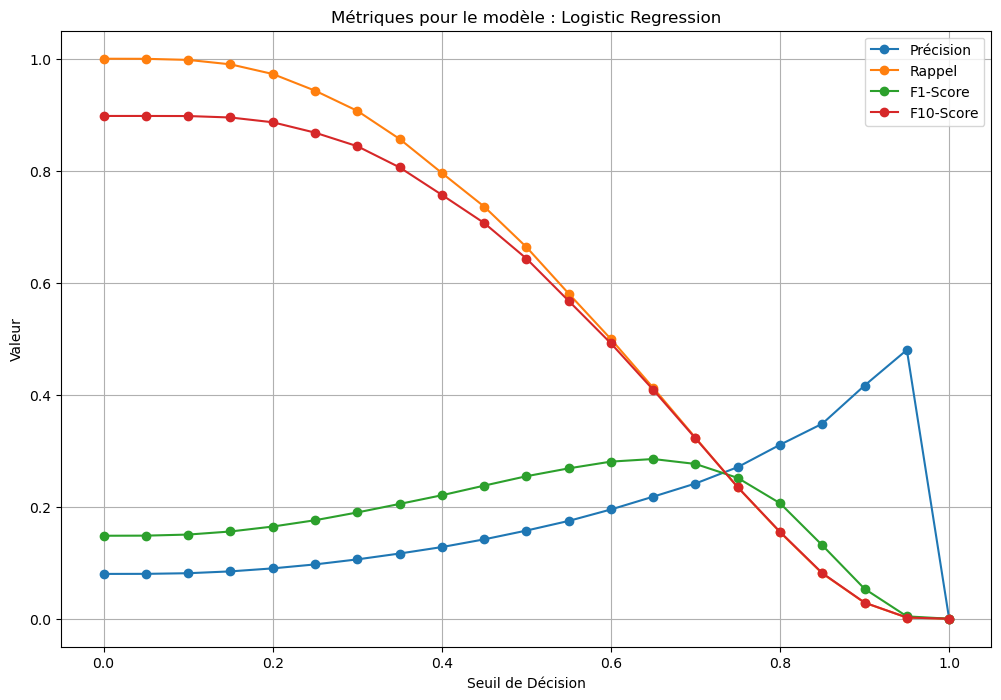

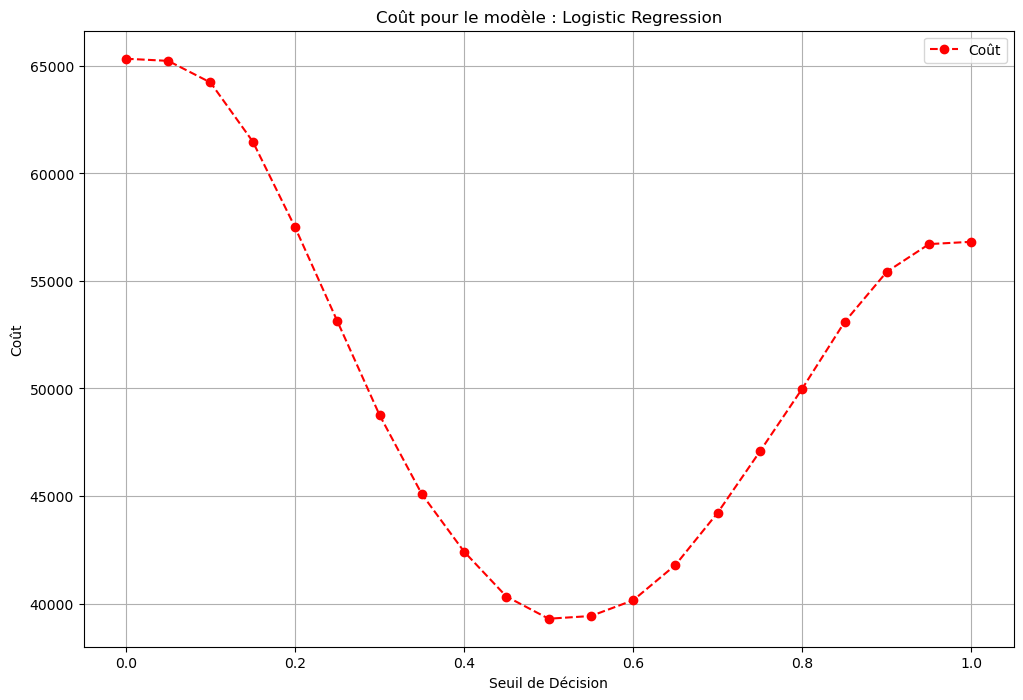


Métriques pour le seuil optimal de 0.50 pour le modèle Logistic Regression :
|    |   Threshold |   Precision |   Recall |   F1-Score |   F10-Score |   ROC AUC |
|---:|------------:|------------:|---------:|-----------:|------------:|----------:|
|  0 |         0.5 |    0.157407 | 0.663675 |   0.254462 |    0.643193 |  0.737763 |

Évaluation des seuils pour le modèle : CatBoost Classifier


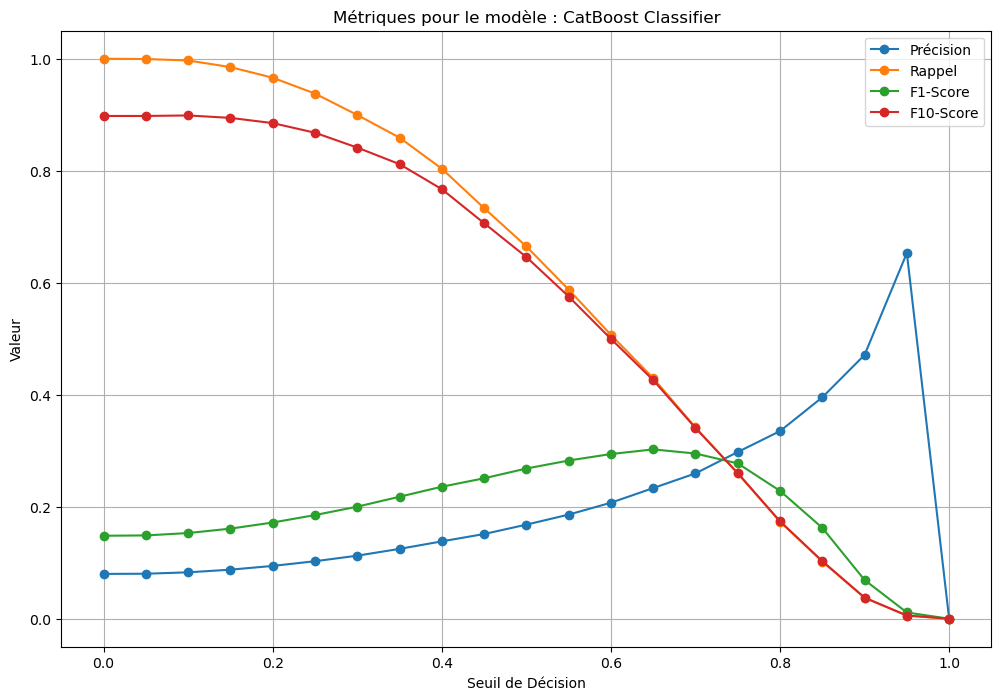

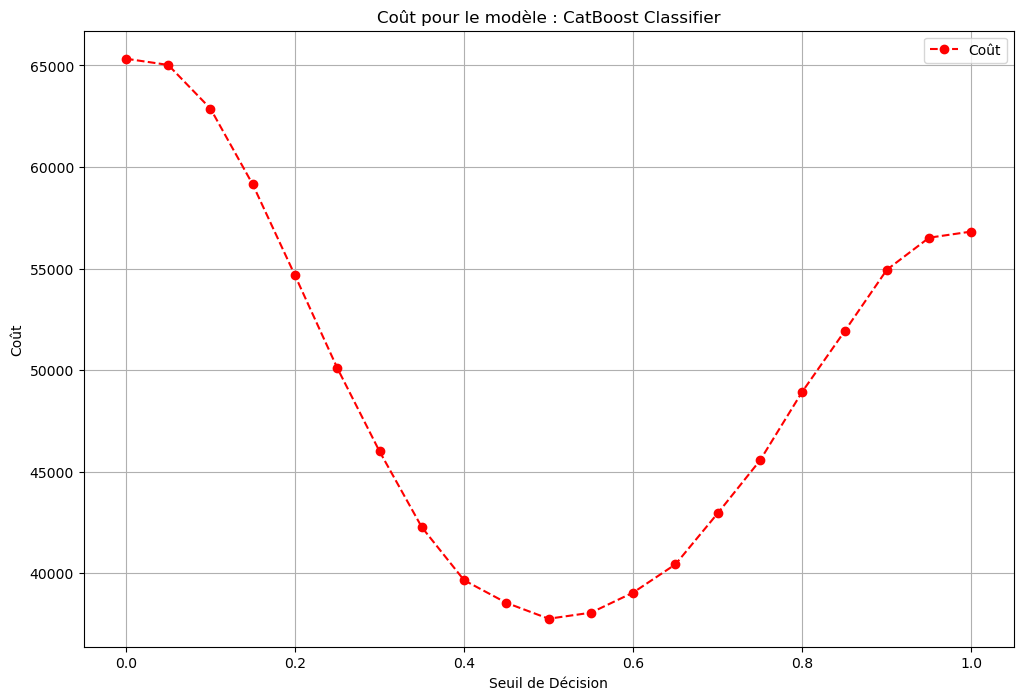


Métriques pour le seuil optimal de 0.50 pour le modèle CatBoost Classifier :
|    |   Threshold |   Precision |   Recall |   F1-Score |   F10-Score |   ROC AUC |
|---:|------------:|------------:|---------:|-----------:|------------:|----------:|
|  0 |         0.5 |    0.168016 | 0.664731 |   0.268234 |    0.645827 |  0.757258 |

Meilleurs hyperparamètres pour chaque modèle :
Modèle: Logistic Regression
Hyperparamètres: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
Modèle: CatBoost Classifier
Hyperparamètres: {'auto_class_weights': 'Balanced', 'bagging_temperature': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'learning_rate': 0.1, 'loss_function': 'Logloss'}

Métriques pour les données d'entraînement :
| Model               |   Threshold |   ROC AUC |   Precision |   Recall |   F1-Score |   Score métier | Matrice           |   1000 estimations |
|:--------------------|------------:|----------:|------------:|---------:|-----------:|---------------:|:----------

<Figure size 1000x500 with 0 Axes>

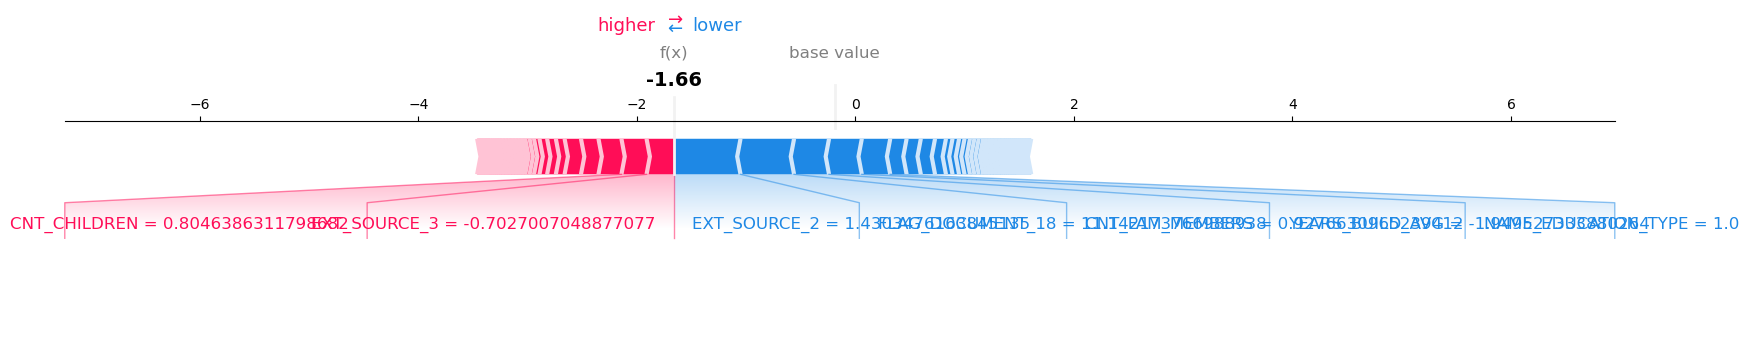

<Figure size 1000x500 with 0 Axes>

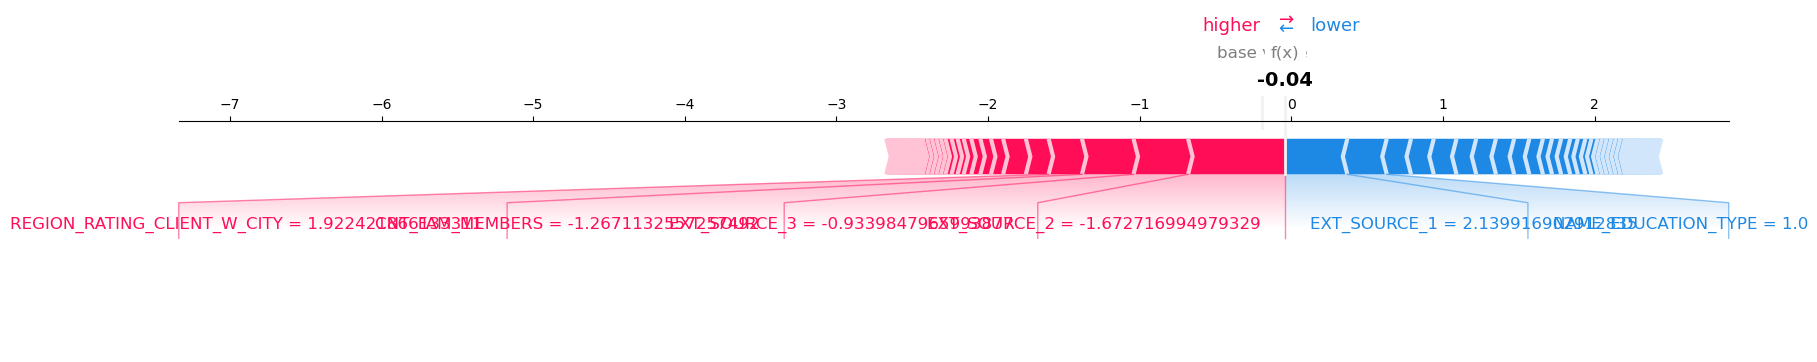

<Figure size 1000x500 with 0 Axes>

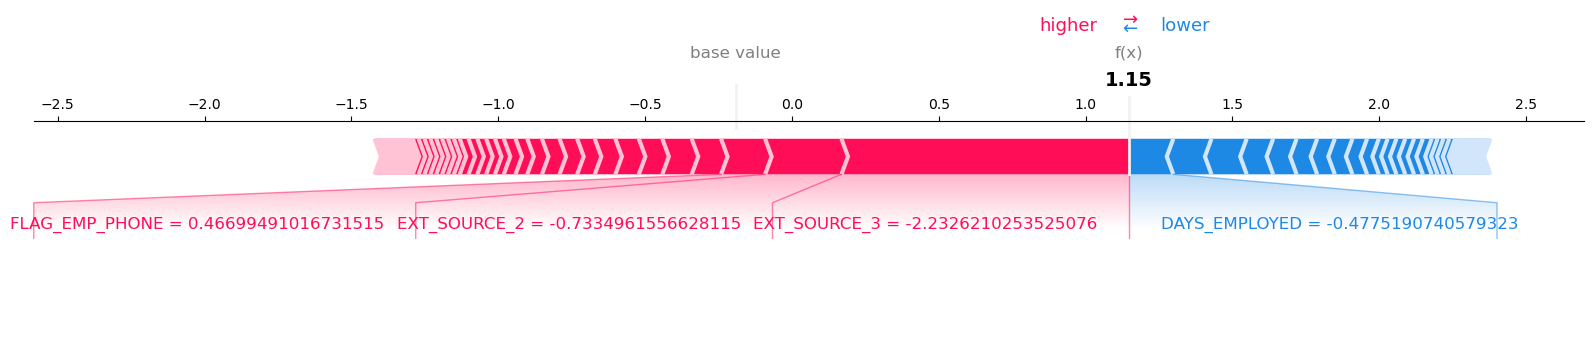

<Figure size 1000x500 with 0 Axes>

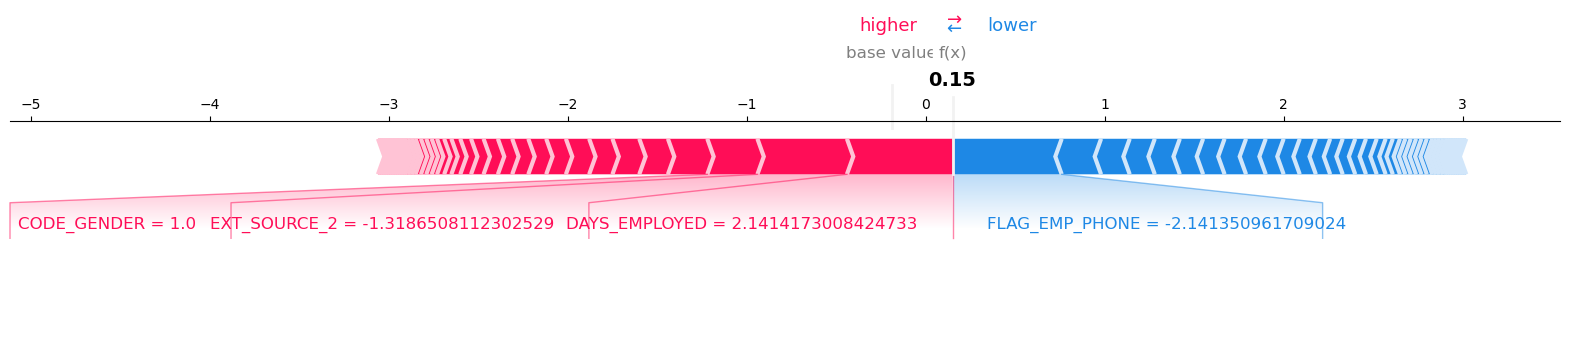

<Figure size 1000x500 with 0 Axes>

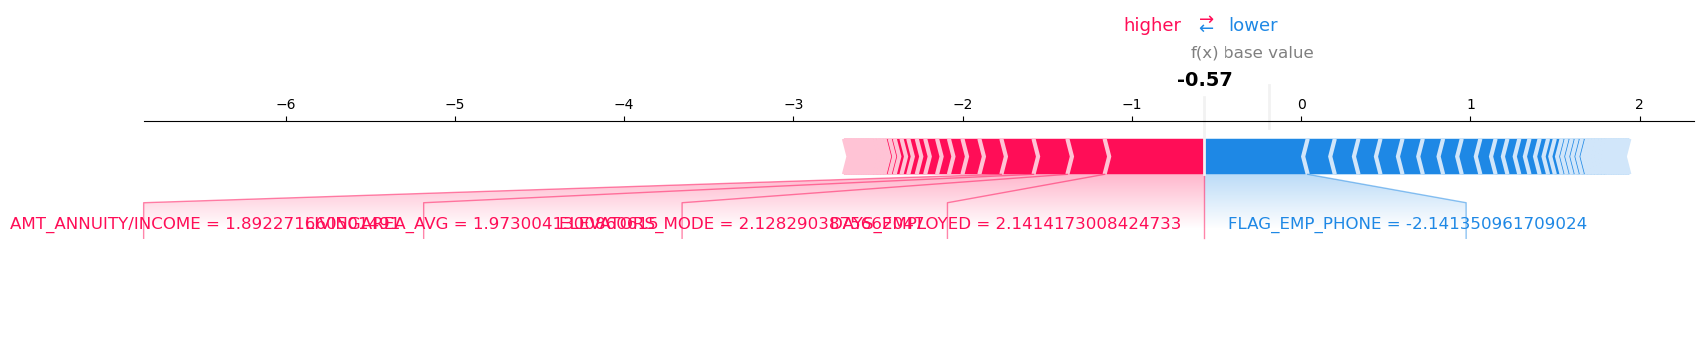

<Figure size 1000x500 with 0 Axes>

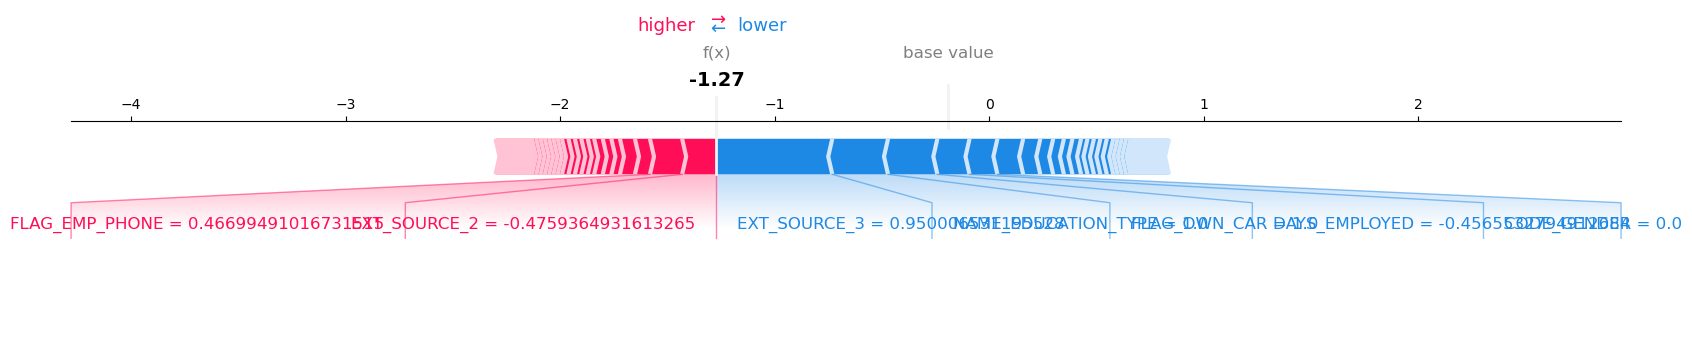

<Figure size 1000x500 with 0 Axes>

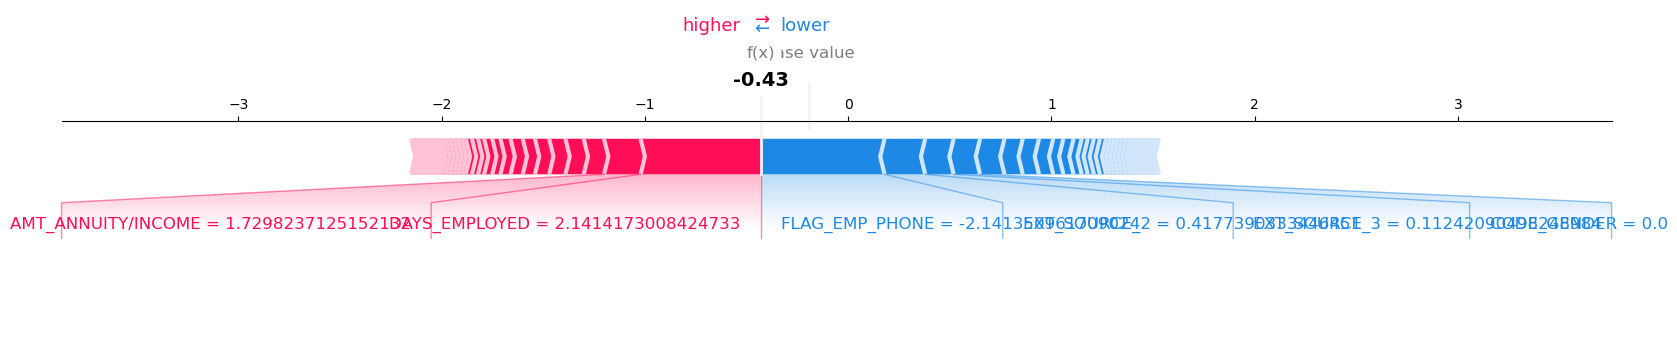

<Figure size 1000x500 with 0 Axes>

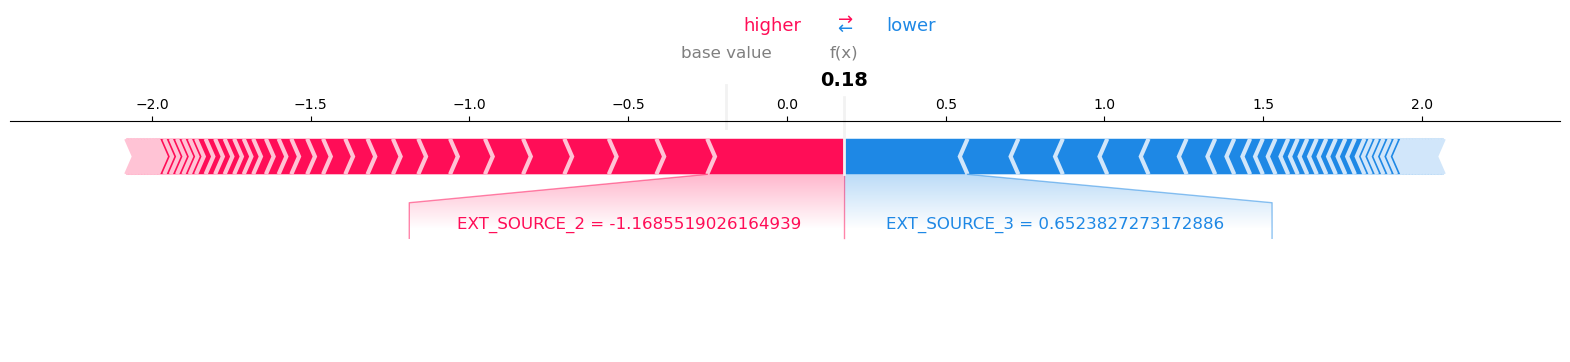

<Figure size 1000x500 with 0 Axes>

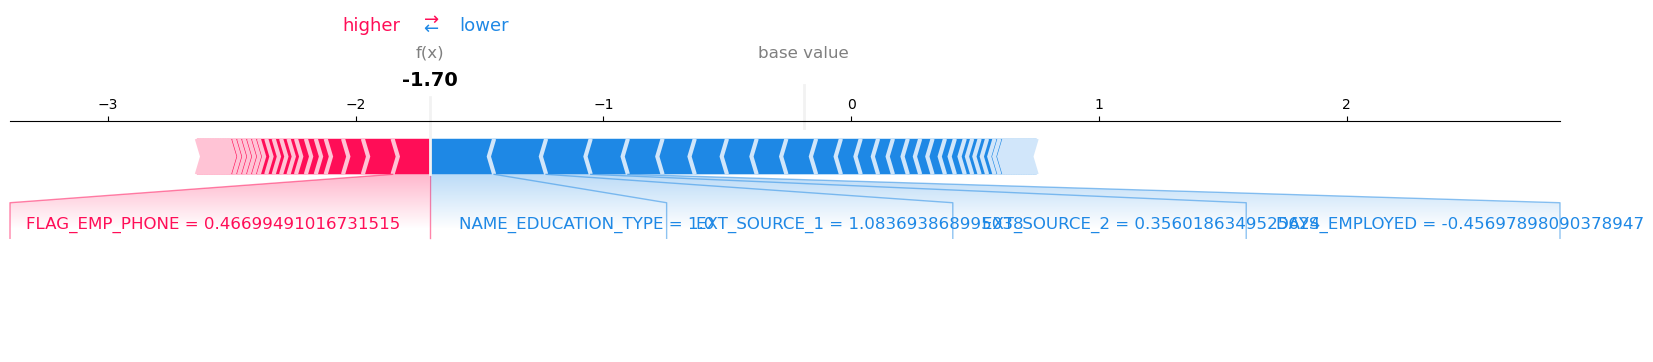

<Figure size 1000x500 with 0 Axes>

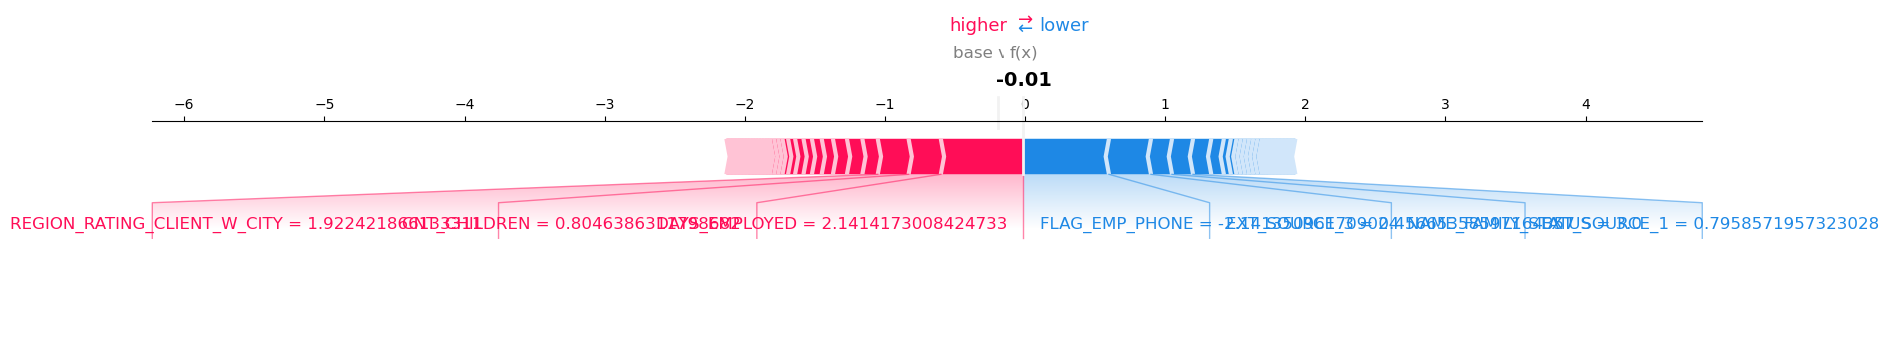

Affichage du SHAP force plot (shap.plots.force)...



Affichage du SHAP summary plot...


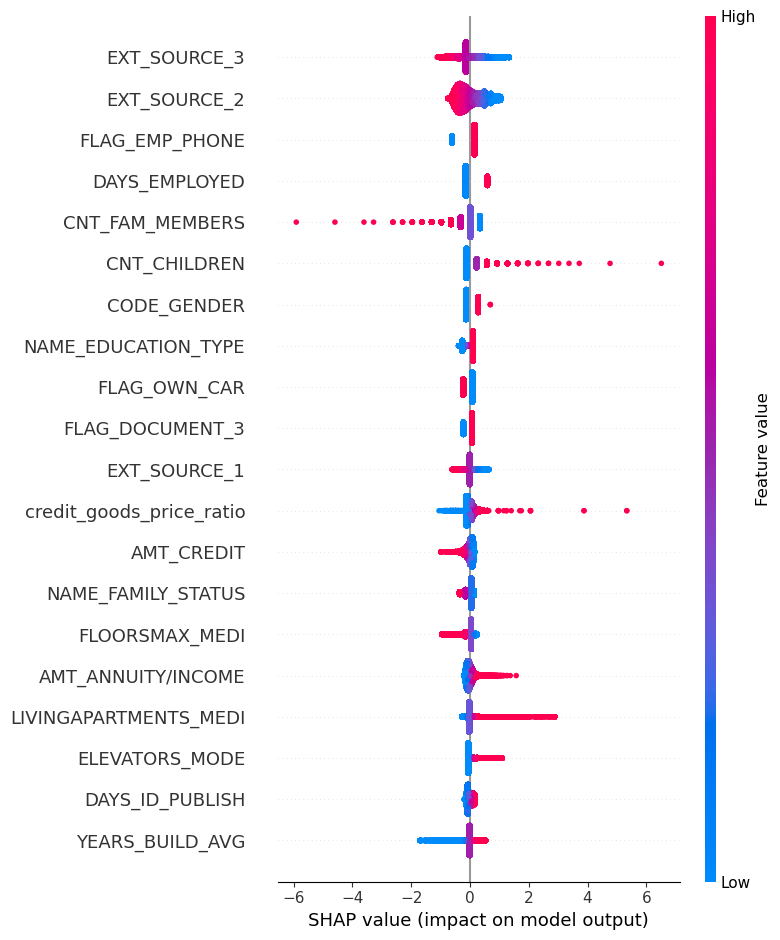


Interprétation de l'importance des variables pour le modèle : CatBoost Classifier

Importance des variables (feature importances) :
|     | Feature                      |   Importance |
|----:|:-----------------------------|-------------:|
|  42 | EXT_SOURCE_3                 |  20.5156     |
|  41 | EXT_SOURCE_2                 |  19.9843     |
| 122 | credit_annuity_ratio         |   9.74222    |
|  40 | EXT_SOURCE_1                 |   7.03379    |
| 123 | credit_goods_price_ratio     |   2.82445    |
|   9 | AMT_GOODS_PRICE              |   2.63753    |
|  16 | DAYS_BIRTH                   |   2.43841    |
|   2 | CODE_GENDER                  |   2.30011    |
|  12 | NAME_EDUCATION_TYPE          |   2.15277    |
|  17 | DAYS_EMPLOYED                |   1.96459    |
| 124 | credit_downpayment           |   1.94252    |
|   8 | AMT_ANNUITY                  |   1.85565    |
|  19 | DAYS_ID_PUBLISH              |   1.3205     |
| 125 | AGE_INT                      |   1.26235    |
|  

100%|===================| 165536/165696 [10:14<00:00]        

Affichage de plusieurs SHAP force plots (shap.force_plot)...


<Figure size 1000x500 with 0 Axes>

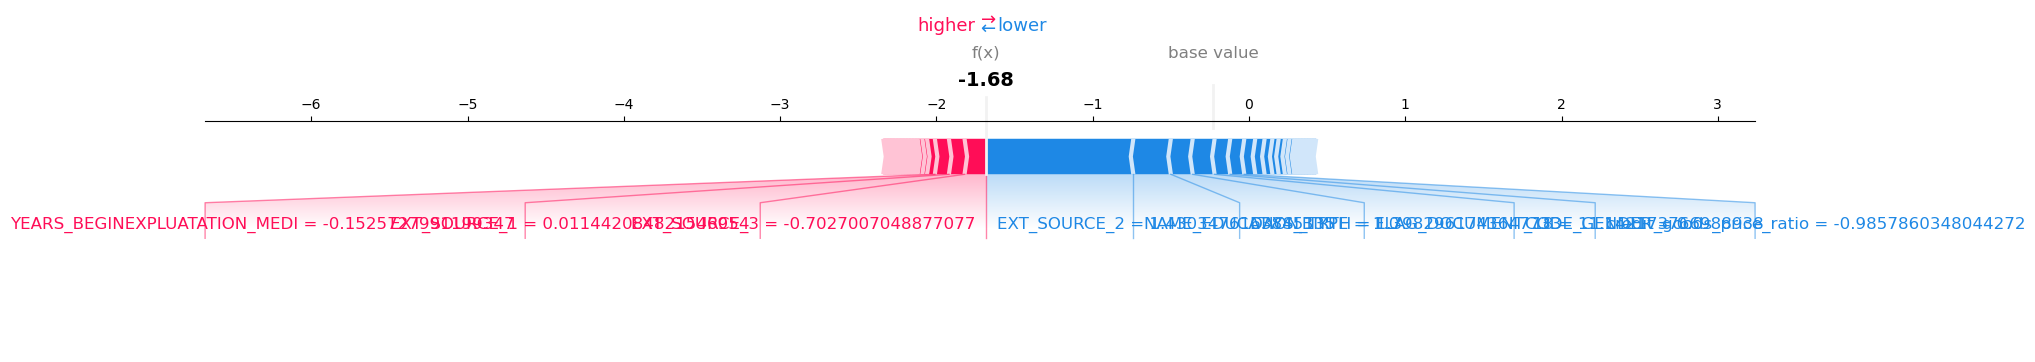

<Figure size 1000x500 with 0 Axes>

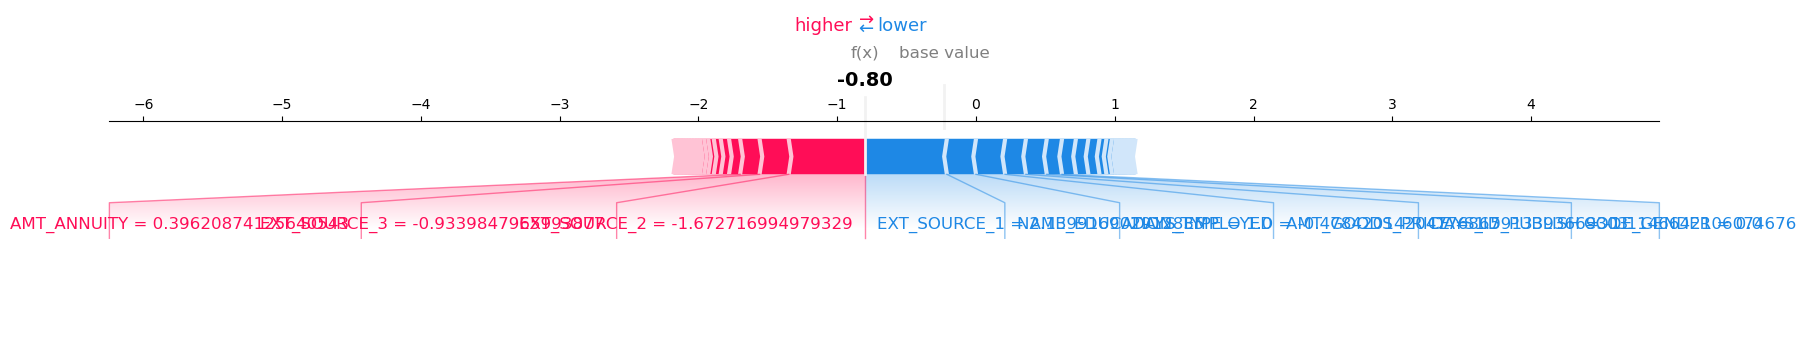

<Figure size 1000x500 with 0 Axes>

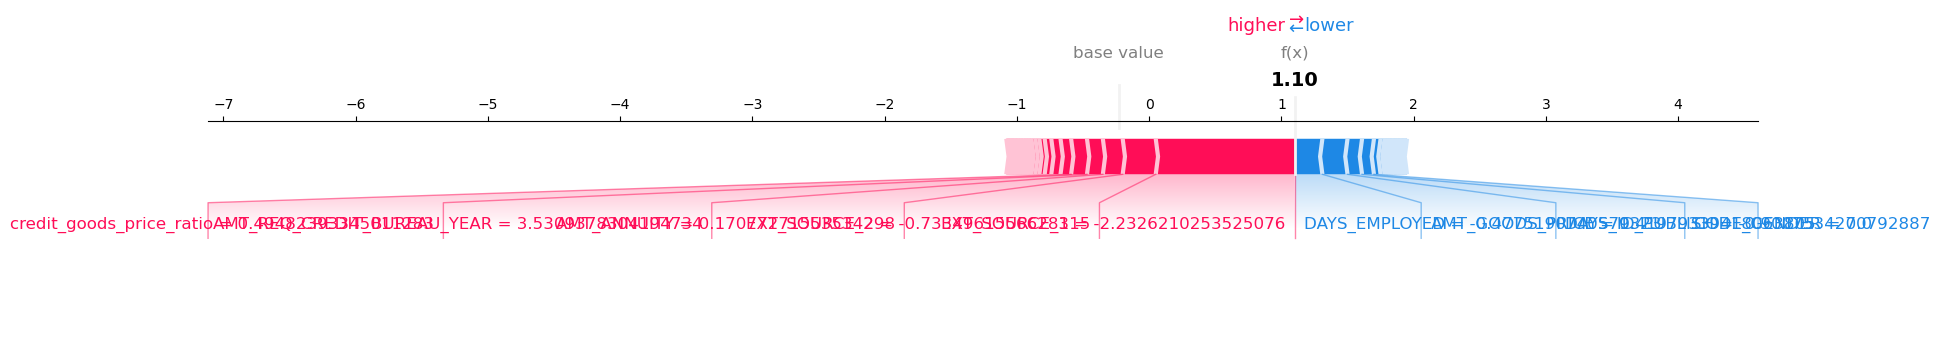

<Figure size 1000x500 with 0 Axes>

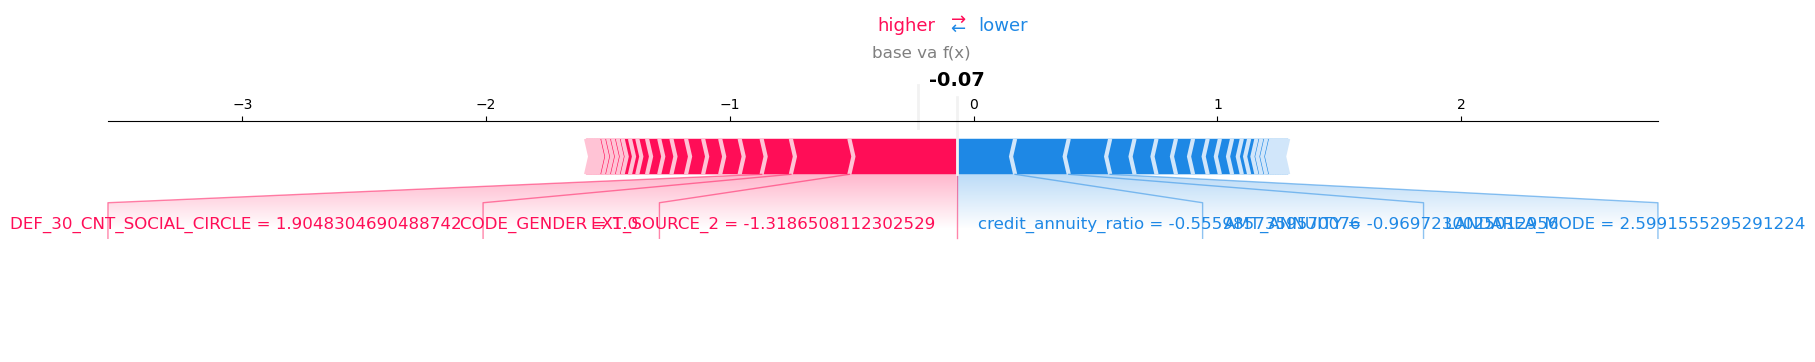

<Figure size 1000x500 with 0 Axes>

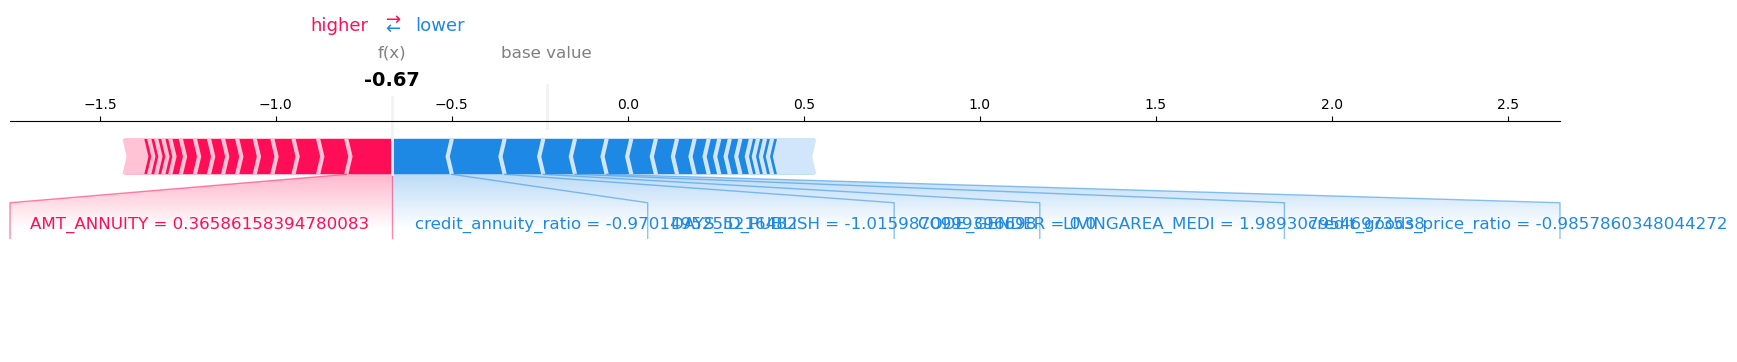

<Figure size 1000x500 with 0 Axes>

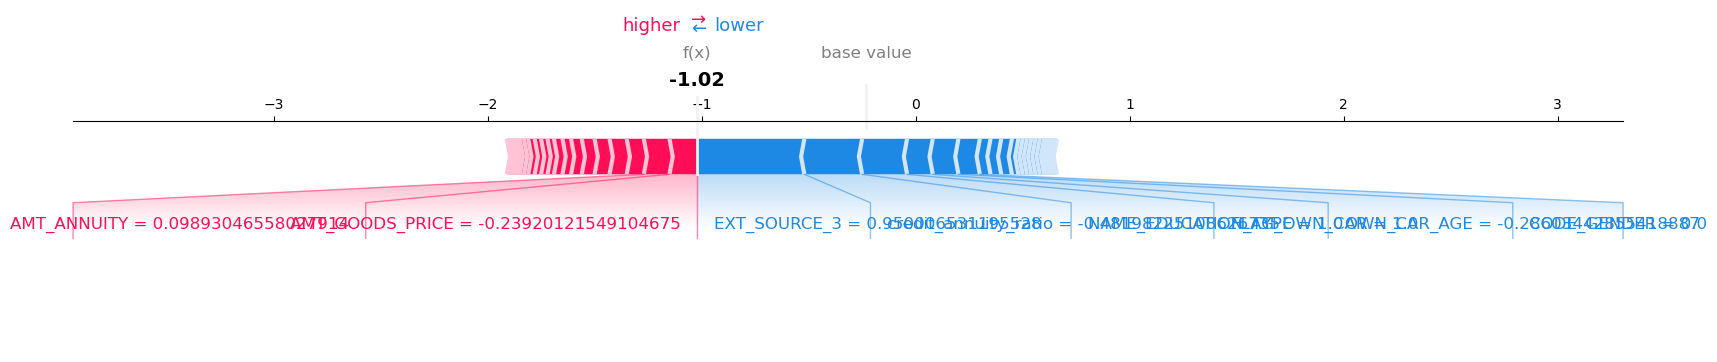

<Figure size 1000x500 with 0 Axes>

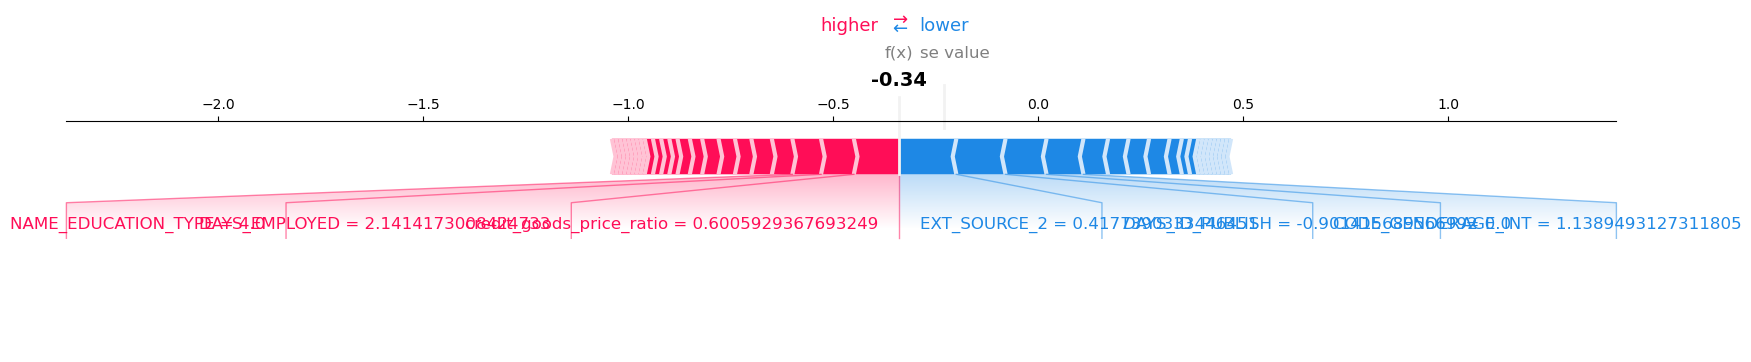

<Figure size 1000x500 with 0 Axes>

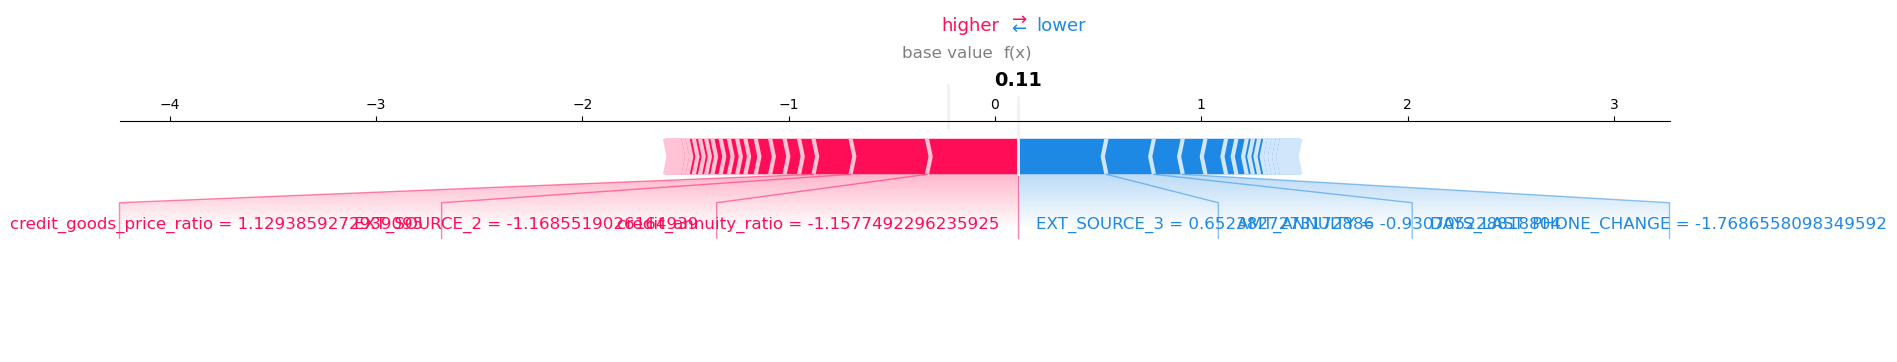

<Figure size 1000x500 with 0 Axes>

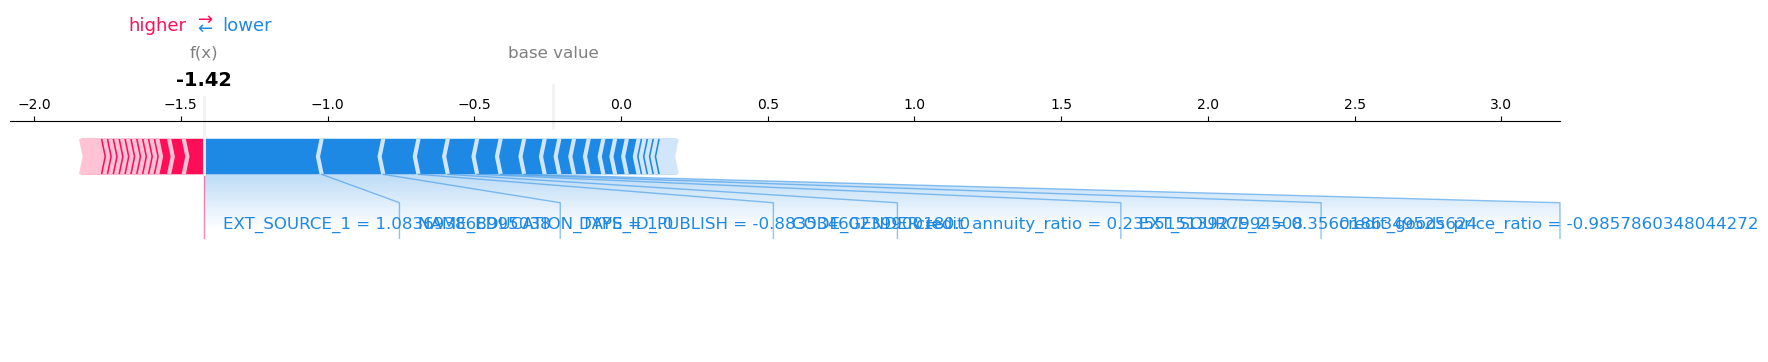

<Figure size 1000x500 with 0 Axes>

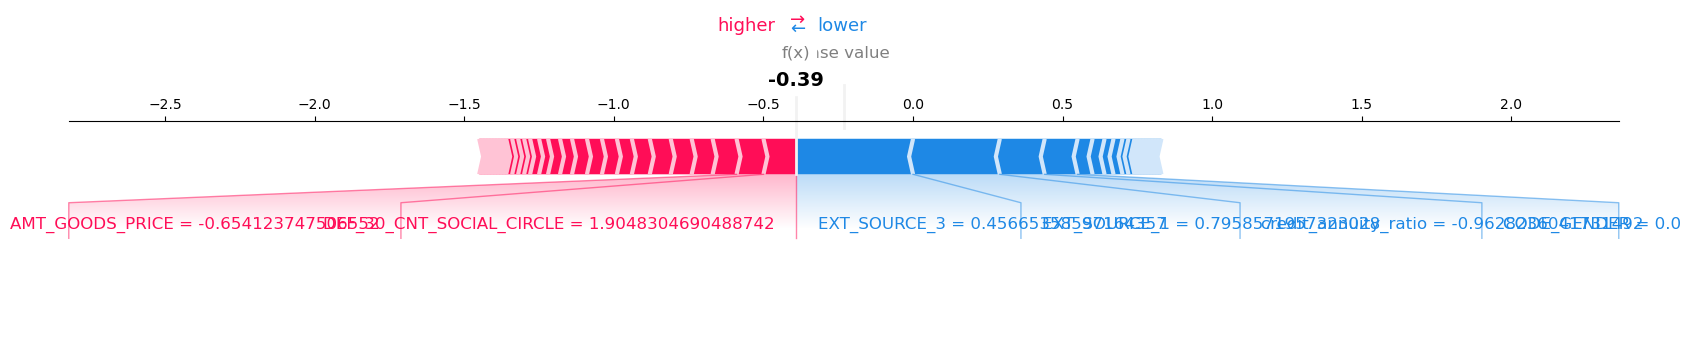

Affichage du SHAP force plot (shap.plots.force)...



Affichage du SHAP summary plot...


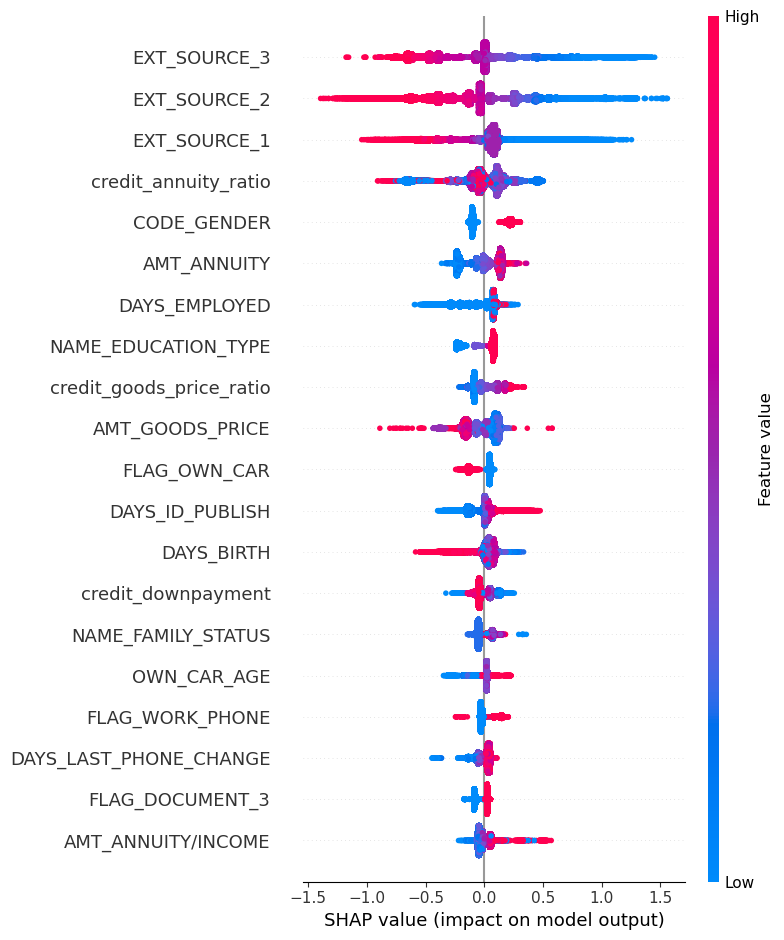

In [164]:
# Appel de la fonction principale avec les chemins des fichiers
metrics_train, metrics_test = process_and_predict('data/application_train_split.csv', 'data/application_test_split.csv')
